In [1]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [1]:
%matplotlib inline

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
 # TODO is this line still needed?
lmtest = importr('lmtest')
# https://stackoverflow.com/questions/32983365/rpy2-cannot-find-installed-external-r-packages
Hmisc = importr("Hmisc")
pandas2ri.activate()

import statsmodels.api as sm
import seaborn as sns
from sklearn.utils import resample
lowess = sm.nonparametric.lowess

In [2]:
# stat functions
def run_r_corr(df, corr_type='spearman', p_correction='BH'):
    """
    Runs R correlation calculations and p-value corrections on the given dataframe.
    
    :returns: a tuple of (correlations, counts, p_values)
    """
    num_cols = len(df.columns.values)
    r_dataframe = pandas2ri.py2ri(df)
    r_as = r['as.matrix']
    rcorr = r['rcorr'] 
    r_p_adjust = r['p.adjust']
    result = rcorr(r_as(r_dataframe), type=corr_type)
    rho = result[0]
    n = result[1]
    p = result[2]
    
    if p_correction is not None:
        p = r_p_adjust(p, p_correction)
    r_corrs = pandas2ri.ri2py(rho)
    r_p_vals = pandas2ri.ri2py(p)
    r_counts = pandas2ri.ri2py(n)
    r_p_vals = np.reshape(r_p_vals, (num_cols,num_cols))
    return r_corrs, r_counts, r_p_vals

def build_corr_mat(corrs, p_vals, labels, title, alpha):
    """
    returns the matplotlib plt object for the specified correlations.
    """
    plt.rcParams["figure.figsize"] = [20,12]
    plt.imshow(corrs)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = "{0:.2f}".format(r_corrs[i, j])
            p = p_vals[i,j]
            if p < alpha / len(labels):
                text = text + "*"
            plt.text(j,i, text, ha="center", va="center", color="w")
    plt.xticks([x for x in range(len(labels))], labels, rotation=45, ha="right", rotation_mode='anchor')
    plt.yticks([x for x in range(len(labels))], labels)
    plt.colorbar()
    plt.title(title)
    return plt


In [3]:
# boostrap test
def bootstrap_lowess(df, x_col, y_col, color, label, n_bootstraps=100, n_samples=100):

    x_min = df[x_col].min()
    x_max = df[x_col].max()
    sample_y = np.zeros((n_bootstraps, n_samples))
    sample_x = np.zeros((n_bootstraps, n_samples))


    for i in range(n_bootstraps):
        resampled_df = resample(df, n_samples=n_samples)
        x = resampled_df[x_col]
        y = resampled_df[y_col]

        filtered = lowess(y, x, return_sorted=True, frac=0.66, it=2)
        sample_y[i, :] = filtered[:, 1]
        sample_x[i, :] = filtered[:, 0]

    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 97.5, axis=0), color=color, ls='--')
    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 50, axis=0), color=color, label=label)
    plt.plot(np.linspace(x_min, x_max, n_samples), np.percentile(sample_y, 2.5, axis=0), color=color, ls='--')
    plt.legend()

groups = {
    'all': ['family_live_together', 'family_live_separate', 'family_together', 'social', 'friend', 'work', 'task', 'sig_other'],
    'social': ['family_live_separate', 'friend', 'social'],
    'work': ['work'],
    'family_together': ['family_live_together', 'sig_other', 'family_together'],
    'task': ['task']
#         'friend': ['friend'],
#         'work': ['work'],
#         'family_live_together': ['family_live_together'],
#         'sig_other': ['sig_other'],
#         'family_live_separate': ['family_live_separate'],
#         'task': ['task']
}

colors = {
    'all': 'red',
    'social': 'blue',
    'work': 'green',
    'family_together': 'orange',
    'task': 'purple'
}    
    
def plot_all_bootstrap_lowess(features, x_col, y_col, ylim, yticks, xlim, xticks, n_bootstraps=100):
    fig = plt.figure()
    fig.add_subplot(111, frameon=False)
    subplot_num = 321
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    for label, contact_types in groups.items():
        plt.subplot(subplot_num)
        df = features.loc[ag_features['contact_type'].isin(contact_types)]
        bootstrap_lowess(df, x_col, y_col, colors[label], label, n_bootstraps=n_bootstraps, n_samples=100)
        plt.ylim(ylim)
        plt.yticks(yticks)
        plt.xlim(xlim)
        plt.xticks(xticks)
        
        subplot_num += 1

    plt.text(64, -0.1, x_col, ha='center')
    plt.text(0.04, 0.5, y_col, va='center', rotation='vertical')
    plt.suptitle("LOWESS of {} as a function of {}".format(y_col, x_col))


# Demographics feature analysis

## Updated abstract

Estimating the category and quality of interpersonal relationships from ubiquitous phone sensor data has potential applications in studying mental well-being and social support. Prior works utilized the volume of communications to estimate broad relationship categories. In this paper, we contextualize communication events by combining phone logs with demographic and location data to predict social roles as well as relationship qualities such as closeness. We explore the role of user demographics in predicting interpersonal relationships and find age to contribute the most to model performance, an interaction with communication trends across social roles. Our findings not only illustrate the value of utilizing data across different modalities, but also underscore the importance of considering population heterogeneity in phone-based mental health studies.

In [4]:
# load age-based features
#with open("../data/final_features/all_contacts_age_gender_dedup_nan_train_features.df", "rb") as f:
#with open("../data/final_features/top10_all_dedup_nan_train_features.df", "rb") as f:
with open("../data/final_features_jan28/top_5_all_train_features.df", "rb") as f:
    ag_features = pickle.load(f)
    
map_dict = {
    "friend": "social",
    "family_live_separate": "social",
    "family_live_together": "family_together",
    "sig_other": "family_together",
    "work": "work",
    "task": "task"
}

#ag_features['contact_type'] = ag_features['contact_type'].map(map_dict)

In [5]:
ag_features.shape

(735, 250)

## Age descriptive statistics

- we see that age is roughly normally distributed, and unsurpisingly there is  no direct relationship between age and social contacts

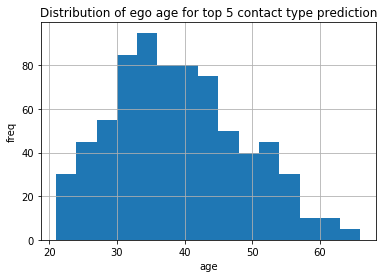

In [6]:
ag_features['ego_age'].hist(bins=15)
plt.ylabel("freq")
plt.xlabel("age")
plt.title("Distribution of ego age for top 5 contact type prediction")
plt.show()

In [7]:
ag_features['ego_age'].describe()

count    735.000000
mean      38.564626
std        9.642145
min       21.000000
25%       31.000000
50%       38.000000
75%       46.000000
max       66.000000
Name: ego_age, dtype: float64

In [8]:
screener_df = pd.read_csv('../CS120/CS120Clinical/CS120Final_Screener.csv', encoding = "ISO-8859-1")
screener_df['pid'] = screener_df['ID']
phq_dict = pd.Series(screener_df['score_PHQ'].values, index=screener_df['pid']).to_dict()
gad_dict = pd.Series(screener_df['score_GAD'].values, index=screener_df['pid']).to_dict()
ag_features['ego_phq'] = ag_features['pid'].map(phq_dict)
ag_features['ego_gad'] = ag_features['pid'].map(gad_dict)

In [9]:
# with open("../data/final_features_jan28/top_5_age_gender_test_features.df", "rb") as f:
#     test_ag_features = pickle.load(f)
    
# test_ag_features.shape

# test_ag_features.drop_duplicates("pid"['ego_age'].describe()

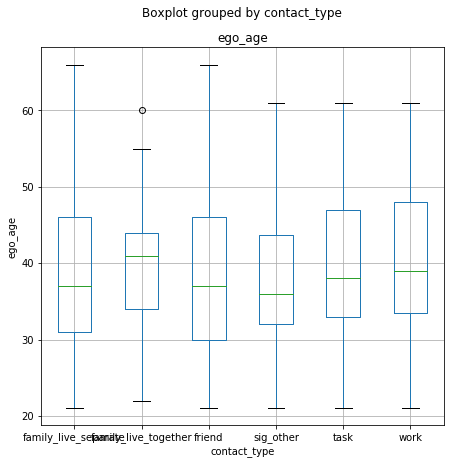

In [10]:
plt.rcParams["figure.figsize"] = [7,7]
ag_features.boxplot(column='ego_age', by='contact_type')
plt.ylabel("ego_age")
plt.savefig("../tex/figures/age_boxplot.png")

## Performance increase when including age/gender

- however, we see the largest increase in test performance when including age and gender, with little further improvement when including other demographics or location-based features

- **Note**: 5-fold CV results show the only performance bump with age/gender, though much smaller from over baseline (66% acc to 68.5% acc)

![](../tex/figures/top5_collapsed_f1_test.png)

## Feature importance using SHAP

[SHAP reference](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)

- we see that time of day call and text frequency are the most important features
- overall comunication volume is also important (total_comm_days, total_comms)

![](../tex/figures/age_gender_shap.png)

In [40]:
# test
with open("../data/final_sandbox/top5_all_train_features.df", "rb") as f:
    ag_features = pickle.load(f)
    

In [65]:
def filter_sig_corrs(r_corrs, r_p_vals, cols, target_col, filter_prefix="", alpha=0.05):
    """Builds a df with correlations for the target_col, optionally providing a prefix filter for columns
    
    """
    target_idx = np.where(cols==target_col)
    target_corrs = r_corrs[target_idx]
    target_p_vals = r_p_vals[target_idx]

    target_stats = np.transpose(np.vstack((target_corrs, target_p_vals)))
    target_df = pd.DataFrame(target_stats, index=cols, columns=['corr', 'p'])
    sig_features = target_df.loc[target_df['p'] < alpha]
    sig_features = sig_features.loc[sig_features.index.str.startswith(filter_prefix)]
    pd.options.display.float_format = '{:,.3f}'.format

    return sig_features.sort_values(by='p')

In [60]:
ag_features_one_hot = pd.concat([ag_features, pd.get_dummies(ag_features['contact_type'])], axis=1)
ag_features_one_hot = ag_features_one_hot.drop(['pid', 'combined_hash', 'contact_type'], axis='columns')
cols = ag_features_one_hot.columns.values
age_idx = np.where(cols=='ego_age')

In [61]:
contact_types = ag_features['contact_type'].unique()

In [67]:
#corr_df = ag_features_one_hot.drop(labels=['pid','combined_hash', 'contact_type'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(ag_features_one_hot, corr_type='pearson')
alpha = 0.01

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/sit

In [100]:
age_idx = np.where(cols=='ego_age')
r_p_vals[age_idx]

array([[1.75351321e-01, 2.99515531e-01, 9.90048249e-01, 1.68499083e-01,
        1.53738029e-02, 7.04457235e-01, 7.37314111e-01, 6.27898863e-03,
        2.75248186e-01, 8.38972732e-01, 9.90048249e-01, 1.94259821e-01,
        1.59326663e-01, 6.36155821e-01, 4.69326118e-02, 7.20946218e-01,
        2.28938060e-01, 9.38868081e-01, 9.90048249e-01, 9.90169514e-01,
        9.90048249e-01, 2.81235855e-01, 1.43776431e-04, 9.36092128e-01,
        6.93069274e-01, 8.91629460e-01, 6.96519690e-01, 1.08856483e-02,
        5.97441739e-01, 8.37669561e-01, 9.57377298e-01, 3.25324779e-01,
        9.88507209e-01, 9.05083238e-01, 7.83751265e-04, 7.99004640e-01,
        8.78875243e-01, 5.01799851e-01, 5.76896028e-01, 1.64242101e-01,
        9.95797128e-01, 9.88120473e-01, 6.04798683e-02, 6.05537102e-02,
        9.90169514e-01, 9.91303911e-01, 4.36213403e-01, 3.18770116e-02,
        4.92555256e-04, 4.42479711e-01, 2.40741896e-01, 3.56607897e-02,
        9.90048249e-01, 2.82708079e-02, 9.90048249e-01, 5.622009

In [68]:
filter_sig_corrs(r_corrs, r_p_vals, cols, 'work', 'ego')

,corr,p


In [69]:
filter_sig_corrs(r_corrs, r_p_vals, cols, 'friend', 'ego')

,corr,p
ego_race_prefer_no_answer,0.164,0.000
ego_ethnicity_not_hispanic,-0.154,0.000
ego_marital_status_married,-0.154,0.000
ego_live_together_alone,0.151,0.000
ego_ethnicity_hispanic,0.145,0.001
ego_marital_status_single,0.145,0.001
ego_employment_unemployed,-0.129,0.003
ego_employment_employed,0.112,0.016
ego_gender_female,-0.107,0.023


In [70]:
filter_sig_corrs(r_corrs, r_p_vals, cols, 'family_live_separate', 'ego')

,corr,p
ego_employment_employed,-0.125,0.005
ego_education_associates,-0.113,0.015
ego_employment_retired,0.110,0.018


In [71]:
filter_sig_corrs(r_corrs, r_p_vals, cols, 'sig_other', 'ego')

,corr,p
ego_ethnicity_hispanic,-0.128,0.004
ego_marital_status_single,-0.128,0.004
ego_ethnicity_not_hispanic,0.120,0.008
ego_marital_status_married,0.120,0.008


In [72]:
filter_sig_corrs(r_corrs, r_p_vals, cols, 'family_live_together', 'ego')

,corr,p
ego_live_together_>=3_others,0.143,0.001
ego_live_together_1_other,-0.114,0.013
ego_education_associates,0.110,0.018
ego_live_together_alone,-0.104,0.030
ego_education_some_hs,0.103,0.032


## All contacts demographic analysis

In [110]:
with open("../data/final_features/all_contacts_all_dedup_nan_train_features.df", "rb") as f:
    all_contacts_features = pickle.load(f)
    

In [111]:
all_contacts_features = pd.concat([all_contacts_features, pd.get_dummies(all_contacts_features['contact_type'])], axis=1)
all_contacts_features = all_contacts_features.drop(['pid', 'combined_hash', 'contact_type'], axis='columns')
cols = all_contacts_features.columns.values
all_contacts_features = all_contacts_features.astype('float64')

In [112]:
all_r_corrs, all_r_counts, all_r_p_vals = run_r_corr(all_contacts_features, corr_type='pearson')

In [113]:
filter_sig_corrs(all_r_corrs, all_r_p_vals, cols, 'work')

,corr,p
task,-0.304,0.000
q2_talk,-0.190,0.000
q3_loan,-0.223,0.000
q4_closeness,-0.176,0.000
family_live_separate,-0.217,0.000
ego_employment_employed,0.115,0.000
friend,-0.270,0.000
total_comm_days,-0.110,0.000
time_of_day_3_call,-0.105,0.000
family_live_together,-0.103,0.000


In [95]:
filter_sig_corrs(all_r_corrs, all_r_p_vals, cols, 'friend', 'ego')

,corr,p
ego_race_prefer_no_answer,0.164,0.000
ego_ethnicity_not_hispanic,-0.154,0.000
ego_marital_status_married,-0.154,0.000
ego_live_together_alone,0.151,0.000
ego_ethnicity_hispanic,0.145,0.001
ego_marital_status_single,0.145,0.001
ego_employment_unemployed,-0.129,0.003
ego_employment_employed,0.112,0.016
ego_gender_female,-0.107,0.023


In [96]:
filter_sig_corrs(all_r_corrs, all_r_p_vals, cols, 'family_live_separate', 'ego')

,corr,p
ego_employment_employed,-0.125,0.005
ego_education_associates,-0.113,0.015
ego_employment_retired,0.110,0.018


In [97]:
filter_sig_corrs(all_r_corrs, all_r_p_vals, cols, 'sig_other', 'ego')

,corr,p
ego_ethnicity_hispanic,-0.128,0.004
ego_marital_status_single,-0.128,0.004
ego_ethnicity_not_hispanic,0.120,0.008
ego_marital_status_married,0.120,0.008


In [84]:
filter_sig_corrs(all_r_corrs, all_r_p_vals, cols, 'family_live_together', 'ego')

,corr,p
ego_live_together_>=3_others,0.143,0.001
ego_live_together_1_other,-0.114,0.013
ego_education_associates,0.110,0.018
ego_live_together_alone,-0.104,0.030
ego_education_some_hs,0.103,0.032


## Zimmerman demographics analysis

In [105]:
with open("../data/final_sandbox/zimmerman_all_train_features.df", "rb") as f:
    z_all_features = pickle.load(f)
    

In [106]:
z_all_features = pd.concat([ag_features, pd.get_dummies(ag_features['contact_type'])], axis=1)
z_all_features = z_all_features.drop(['pid', 'combined_hash', 'contact_type'], axis='columns')
cols = z_all_features.columns.values
z_all_features = z_all_features.astype('float64')

## Point Biserial exploration

In [16]:

pbr_results = np.zeros((ag_features_one_hot.columns.values.shape[0], len(contact_types)*2))

for col_idx, col in enumerate(ag_features_one_hot.columns.values):
    for contact_idx, contact in enumerate(contact_types):
        r, p = pointbiserialr(ag_features_one_hot[col], ag_features_one_hot[contact])
        pbr_results[col_idx, contact_idx*2] = r
        pbr_results[col_idx, (contact_idx*2)+1] = p

df_cols = []
for contact in ag_features['contact_type'].unique():
    df_cols.append('t_' + contact)
    df_cols.append('p_' + contact)
#pd.options.display.float_format = '${:,.3f}'.format
pbr_df = pd.DataFrame(pbr_results, index=cols, columns=df_cols)

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [17]:
pb_sig_df = pbr_df.loc[(pbr_df['p_friend'] < 0.05) | (pbr_df['p_family_live_together'] < 0.05) | (pbr_df['p_family_live_separate'] < 0.05) | (pbr_df['p_sig_other'] < 0.05) | (pbr_df['p_task'] < 0.05) | (pbr_df['p_work'] < 0.05)]
pb_sig_df.loc[pb_sig_df.index[pb_sig_df.index.str.startswith("ego")]]

,t_family_live_separate,p_family_live_separate,t_friend,p_friend,t_sig_other,p_sig_other,t_family_live_together,p_family_live_together,t_task,p_task,t_work,p_work
ego_gender_female,0.083465,0.023641,-0.107309,0.003583,0.023004,0.533492,0.077170,0.036465,0.023993,0.516049,-0.092631,0.011990
ego_gender_male,-0.069518,0.059597,0.088628,0.016242,-0.004534,0.902341,-0.061415,0.096164,-0.020902,0.571544,0.059167,0.108993
ego_gender_other,-0.046853,0.204522,0.042288,0.252201,-0.041618,0.259798,-0.041332,0.263092,0.004784,0.896987,0.094974,0.009987
ego_education_associates,-0.113009,0.002152,0.022344,0.545308,0.018052,0.625119,0.110480,0.002706,-0.062868,0.088533,0.065287,0.076915
ego_education_completed_hs,0.088154,0.016825,-0.064227,0.081844,0.020500,0.578981,-0.045749,0.215411,0.052189,0.157524,-0.059861,0.104897
ego_education_some_hs,0.038972,0.291346,-0.060529,0.101068,0.009980,0.787071,0.102847,0.005256,-0.044957,0.223464,-0.042641,0.248252
ego_employment_employed,-0.124861,0.000692,0.111704,0.002423,-0.049924,0.176372,-0.000363,0.992165,-0.013272,0.719423,0.084817,0.021466
ego_employment_retired,0.110275,0.002756,-0.032607,0.377373,-0.041618,0.259798,-0.003827,0.917504,-0.036581,0.321991,-0.034696,0.347561
ego_employment_unemployed,0.087523,0.017628,-0.129349,0.000439,0.060463,0.101440,0.009781,0.791216,0.026929,0.466021,-0.029977,0.417081
ego_live_together_1_other,0.009796,0.790904,-0.034408,0.351586,0.053378,0.148260,-0.114006,0.001964,0.062268,0.091623,0.047878,0.194789


In [18]:
pb_sig_styled = pb_sig_df.loc[:, pb_sig_df.columns.str.startswith("p")].style.apply(lambda x: ["background: yellow" if np.abs(v) < 0.05 else "" for v in x], axis = 1)

pb_sig_styled

,p_family_live_separate,p_friend,p_sig_other,p_family_live_together,p_task,p_work
total_comms,0.0779299,0.686883,0.00348776,0.967789,0.168977,0.245684
total_comm_days,0.0172785,0.0756869,7.18207e-17,6.63477e-07,2.41086e-05,0.00016804
total_calls,0.195036,0.000172667,2.71488e-14,0.036996,0.16334,0.325524
total_sms,0.0842273,0.825078,0.00959164,0.883736,0.141844,0.258238
total_sms_days,0.0264105,0.713773,7.63556e-08,0.000269295,7.05657e-05,0.00135216
total_call_days,0.334345,2.00776e-06,2.27554e-16,3.8091e-05,0.049905,0.0269047
reg_call,0.328428,1.13501e-07,1.16075e-17,4.16761e-05,0.0528464,0.100776
reg_sms,0.0364997,0.969175,6.74483e-10,0.00424103,0.000356283,0.00110164
reg_comm,0.0309915,0.0164362,1.23263e-19,2.22684e-05,0.00015756,0.000542713
time_of_day_0_call,0.033831,0.903057,0.183465,0.931622,0.767938,0.180395


## Checking for missing EMA values

In [73]:
emc_all = pickle.load(open("../data/emc_all.df", "rb"))

In [75]:
emc_no_other = emc_all[~(emc_all['contact_type'] == 'other')]

## Age analysis in the context of communication features

In [19]:
corr_df = ag_features.drop(labels=['pid','combined_hash', 'contact_type'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')
alpha = 0.01
# plt = build_corr_mat(r_corrs, 
#                      r_p_vals, 
#                      corr_df.columns.values, 
#                      "Across subject pearson correlations, significance* at FDR<{}".format(alpha),
#                      alpha)
# plt.show()

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/sit

IndexError: invalid index to scalar variable.

In [20]:
cols = corr_df.columns.values
age_idx = np.where(cols=='ego_age')

### significant correlations with age (FDR < 0.05), Benjamini-Hochberg corrected

- some of the time of day, day of week communication features are significantly correlated with age

In [21]:
age_corrs = r_corrs[age_idx]
age_p_vals = r_p_vals[age_idx]

age_stats = np.transpose(np.vstack((age_corrs, age_p_vals)))
age_df = pd.DataFrame(age_stats, index=cols, columns=['corr', 'p'])
sig_features = age_df.loc[age_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.str.startswith("ego")]
sig_features = sig_features.loc[~sig_features.index.str.endswith("indicator")]
sig_features = sig_features.loc[~sig_features.index.str.startswith("q")]
pd.options.display.float_format = '{:,.5f}'.format

sig_features.sort_values(by='p')
#sig_features.shape

NameError: name 'r_corrs' is not defined

### Observations

- as age increases:
    - willingness for communication increases
    - willingness to talk about importance matters decreases
    - willingness to ask for loans decreases
    - duration of call duration increases
    - tendency to call over text increases
    - less communication on Saturday
    - less texts in the evening
    
- argument: people of different age groups communicate with their friends, family differently

### EMC correlations

In [22]:
age_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

NameError: name 'age_df' is not defined

In [25]:
ag_features.columns.values

array(['pid', 'combined_hash', 'total_comms', 'total_comm_days',
       'contact_type', 'total_calls', 'total_sms', 'total_sms_days',
       'total_call_days', 'reg_call', 'reg_sms', 'reg_comm',
       'time_of_day_0_call', 'time_of_day_1_call', 'time_of_day_2_call',
       'time_of_day_3_call', 'time_of_day_4_call', 'time_of_day_5_call',
       'day_0_call', 'day_1_call', 'day_2_call', 'day_3_call',
       'day_4_call', 'day_5_call', 'day_6_call', 'time_of_day_0_sms',
       'time_of_day_1_sms', 'time_of_day_2_sms', 'time_of_day_3_sms',
       'time_of_day_4_sms', 'time_of_day_5_sms', 'day_0_sms', 'day_1_sms',
       'day_2_sms', 'day_3_sms', 'day_4_sms', 'day_5_sms', 'day_6_sms',
       'time_of_day_0_call_dur', 'time_of_day_1_call_dur',
       'time_of_day_2_call_dur', 'time_of_day_3_call_dur',
       'time_of_day_4_call_dur', 'time_of_day_5_call_dur',
       'day_0_call_dur', 'day_1_call_dur', 'day_2_call_dur',
       'day_3_call_dur', 'day_4_call_dur', 'day_5_call_dur',
       'da

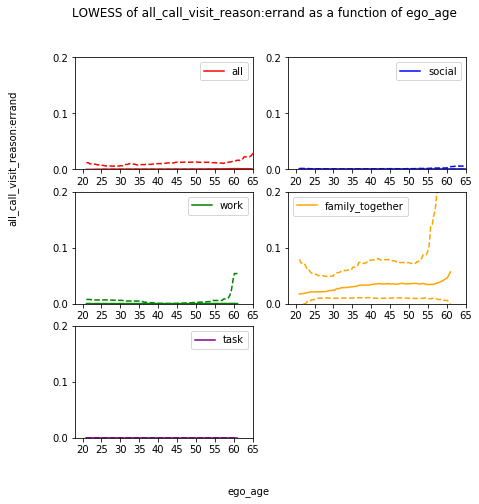

In [28]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'all_call_visit_reason:errand', (0,0.2), np.arange(0, 0.21, 0.1), (18, 65), np.arange(20, 66, 5), 100)


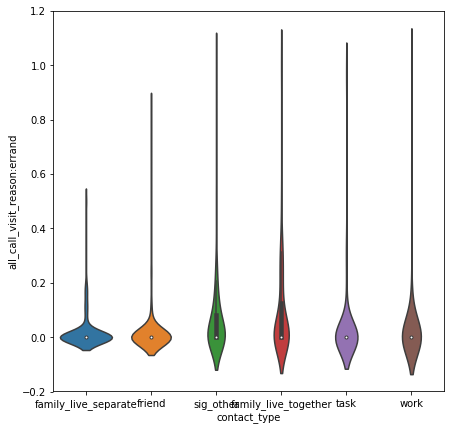

In [29]:
sns.violinplot(x="contact_type", y="all_call_visit_reason:errand", data=ag_features, split=True)
plt.show()

### Observations

- as age increases:
    - willingness for communication increases
    - willingness to talk about importance matters decreases
    - willingness to ask for loans decreases
    - duration of call duration increases
    - tendency to call over text increases
    - less communication on Saturday
    - less texts in the evening
    
- argument: people of different age groups communicate with their friends, family differently

## LOWESS

- If we analyze the distribution of temporal features as a function of age across the different contact types, we see some variations in trends 

### Temporal features

### Night (8pm - 12am) texts
- most important temporal feature, according to SHAP analysis
- Though the overall trend is downward (see "all" line in blue), there are large variations in trends across contact types within our population
- overall trend: the older you are, the less frequent texts at night are
- however, only "task" and "social" contacty types correctly track this trend
- **note**: dotted lines are 95% CI, over 1000 bootstraps

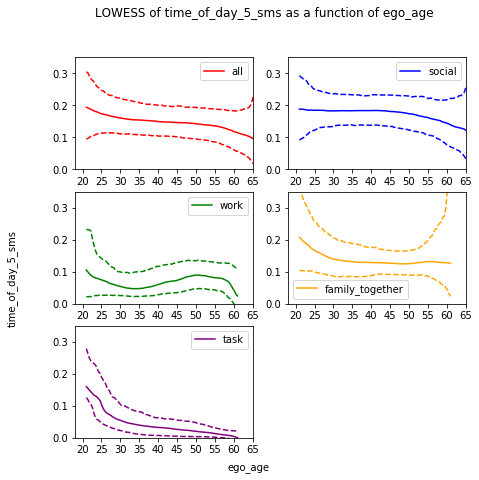

In [23]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'time_of_day_5_sms', (0,0.35), np.arange(0, 0.35, 0.1), (18, 65), np.arange(20, 66, 5), 1000)
#plt.savefig("../tex/figures/lowess_time_of_day_5.png", dpi=300)

In [ ]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'time_of_day_0_sms', (0,0.1), np.arange(0, 0.11, 0.02), (18, 65), np.arange(20, 66, 5), 1000)

### Late morning (8 am - 12 pm) calls

- second-most important temporal communication feature
- less divergence in distribution across the different contact types other than task

In [ ]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'time_of_day_3_calls', (0,0.4), np.arange(0, 0.45, 0.1), (18, 65), np.arange(20, 66, 5), 1000)

### Night (8pm - 12 am) calls


In [ ]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'time_of_day_5_calls', (0,0.35), np.arange(0, 0.35, 0.1), (18, 65), np.arange(20, 66, 5), 1000)

### Regularity features

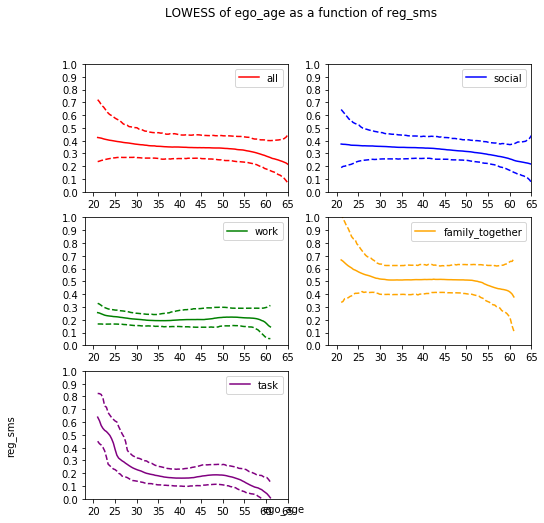

In [234]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'reg_sms', (0,1), np.arange(0, 1.1, .1), (18, 65), np.arange(20, 66, 5), 1000)

### Channel selection features

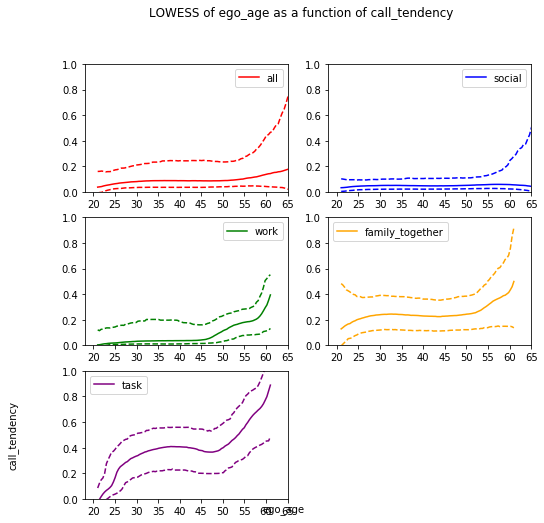

In [243]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'call_tendency', (0,1), np.arange(0, 1.1, .2), (18, 65), np.arange(20, 66, 5), 1000)

## EMC results

- in contrast, we largely see agreement in EMC responses for different contact types, regardless of age
- this is unsurprising as these qualitative measures should not vary too much across age groups

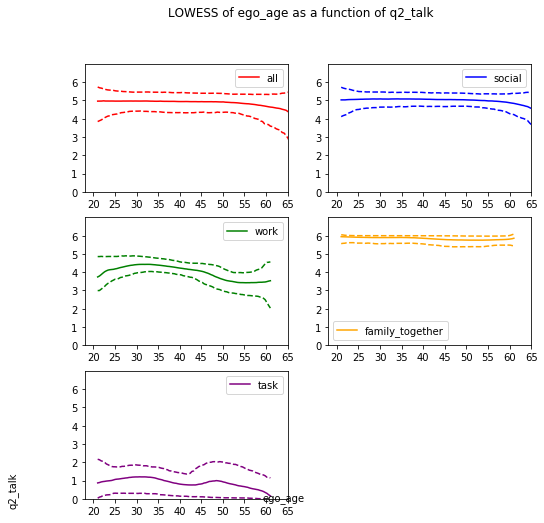

In [296]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'q2_talk', (0,7), np.arange(0, 7, 1), (18, 65), np.arange(20, 66, 5), 1000)

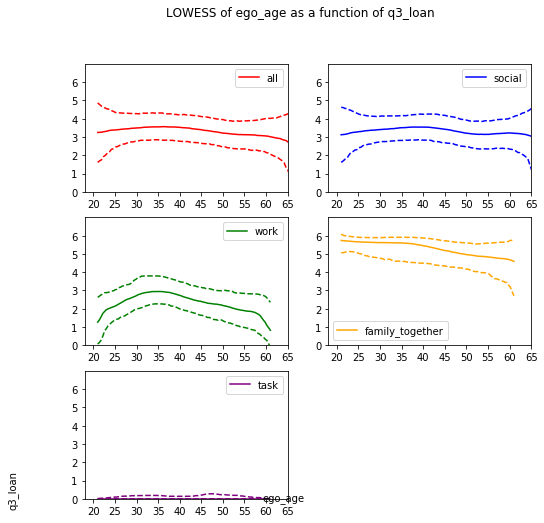

In [297]:
plot_all_bootstrap_lowess(ag_features, 'ego_age', 'q3_loan', (0,7), np.arange(0, 7, 1), (18, 65), np.arange(20, 66, 5), 1000)

## Gender differences in communication patterns

- we run a paired t-test between male and female participant communication features, across our different contact types
- highlighed are significant p-values (< 0.05)

### Notes

- as age increases:
    - willingness for communication increases
    - willingness to talk about importance matters decreases
    - willingness to ask for loans decreases
    - duration of call duration increases
    - tendency to call over text increases
    - less communication on Saturday
    - less texts in the evening
    
- argument: people of different age groups communicate with their friends, family differently

In [334]:
from scipy.stats import ttest_ind, mannwhitneyu

male_df = ag_features.loc[ag_features['ego_gender_male'] == 1]
female_df = ag_features.loc[ag_features['ego_gender_female'] == 1]

ttest_results = np.zeros((corr_df.columns.values.shape[0], 8))
for col_idx, col in enumerate(corr_df.columns.values):
    print(col)
    for contact_idx, contact in enumerate(ag_features['contact_type'].unique()):
        male_target = male_df.loc[male_df['contact_type'] == contact][col]
        female_target = female_df.loc[female_df['contact_type'] == contact][col]
#         t, p = ttest_ind(male_target, female_target)
        t, p = mannwhitneyu(male_target, female_target)
        ttest_results[col_idx, contact_idx*2] = t
        ttest_results[col_idx, (contact_idx*2)+1] = p

df_cols = []
for contact in ag_features['contact_type'].unique():
    df_cols.append('t_' + contact)
    df_cols.append('p_' + contact)
pd.options.display.float_format = '${:,.3f}'.format
ttest_df = pd.DataFrame(ttest_results, index=corr_df.columns.values, columns=df_cols)



total_comms
total_comm_days
total_calls
total_sms
total_sms_days
total_call_days
total_days
reg_call
reg_sms
reg_comm
time_of_day_0_calls
time_of_day_1_calls
time_of_day_2_calls
time_of_day_3_calls
time_of_day_4_calls
time_of_day_5_calls
day_0_calls
day_1_calls
day_2_calls
day_3_calls
day_4_calls
day_5_calls
day_6_calls
time_of_day_0_sms
time_of_day_1_sms
time_of_day_2_sms
time_of_day_3_sms
time_of_day_4_sms
time_of_day_5_sms
day_0_sms
day_1_sms
day_2_sms
day_3_sms
day_4_sms
day_5_sms
day_6_sms
mean_in_call
std_in_call
min_in_call
med_in_call
max_in_call
mean_out_call
std_out_call
min_out_call
med_out_call
max_out_call
mean_in_sms
std_in_sms
min_in_sms
med_in_sms
max_in_sms
mean_out_sms
std_out_sms
min_out_sms
med_out_sms
max_out_sms
out_comm
call_tendency
missed_in_calls
missed_out_calls
in_out_sms
avg_in_duration
max_in_duration
avg_out_duration
max_out_duration
time_of_day_0_calls_nan_indicator
time_of_day_1_calls_nan_indicator
time_of_day_2_calls_nan_indicator
time_of_day_3_calls_n

ValueError: All numbers are identical in mannwhitneyu

In [ ]:
t_sig_df = ttest_df.loc[(ttest_df['p_social'] < 0.05) | (ttest_df['p_family_together'] < 0.05) | (ttest_df['p_task'] < 0.05) | (ttest_df['p_work'] < 0.05)]
t_sig_df = t_sig_df.loc[~t_sig_df.index.str.endswith("indicator")]
t_sig_df = t_sig_df.loc[~t_sig_df.index.str.startswith("ego")]

In [ ]:
t_sig_styled = t_sig_df.style.apply(lambda x: ["background: yellow" if np.abs(v) < 0.05 else "" for v in x], axis = 1)
t_sig_styled

### Significant features

- note: many of the significant communication features appear to be due to outliers

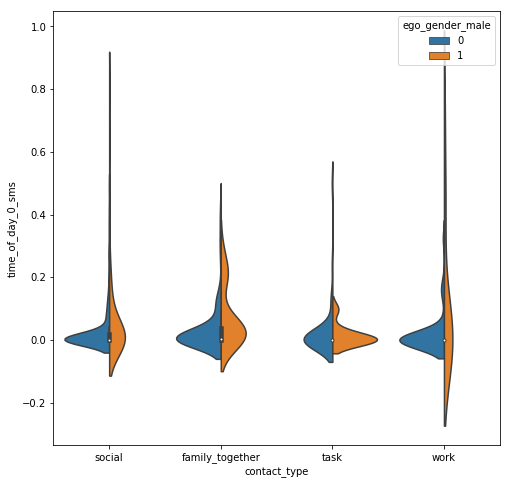

In [298]:
import seaborn as sns
sns.violinplot(x="contact_type", y="time_of_day_0_sms", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

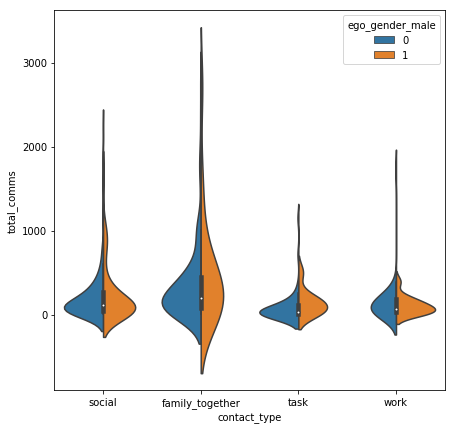

In [331]:
ag_features_no_outliers = ag_features.loc[ag_features['total_comms'] < 3000]
sns.violinplot(x="contact_type", y="total_comms", hue="ego_gender_male", data=ag_features_no_outliers, split=True)
plt.show()

### Temporal features

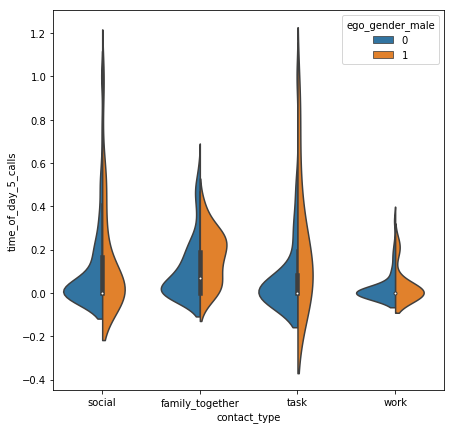

In [332]:
sns.violinplot(x="contact_type", y="time_of_day_5_calls", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

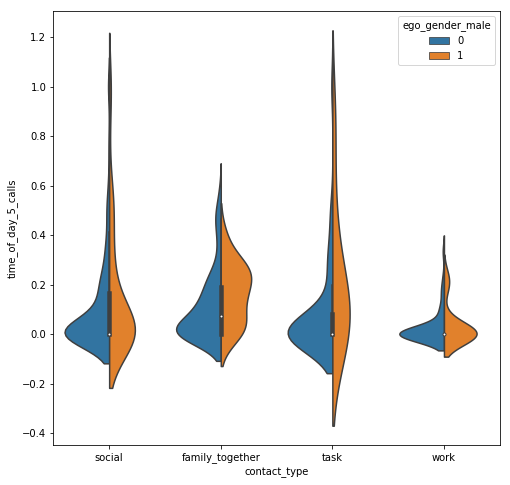

In [301]:
sns.violinplot(x="contact_type", y="time_of_day_5_calls", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

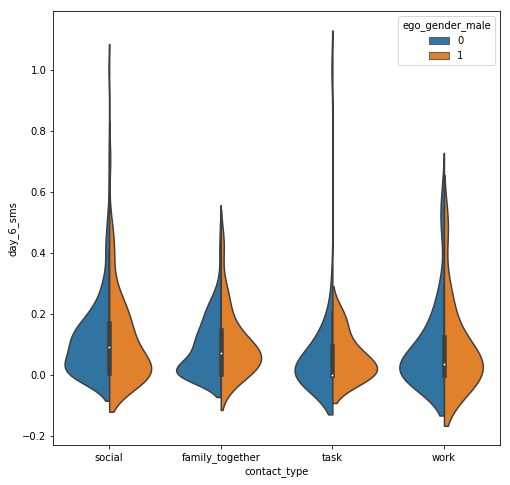

In [302]:
sns.violinplot(x="contact_type", y="day_6_sms", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

### Regularity features

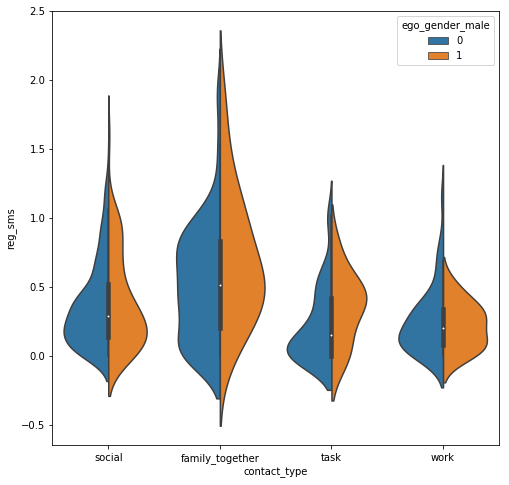

In [303]:
sns.violinplot(x="contact_type", y="reg_sms", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

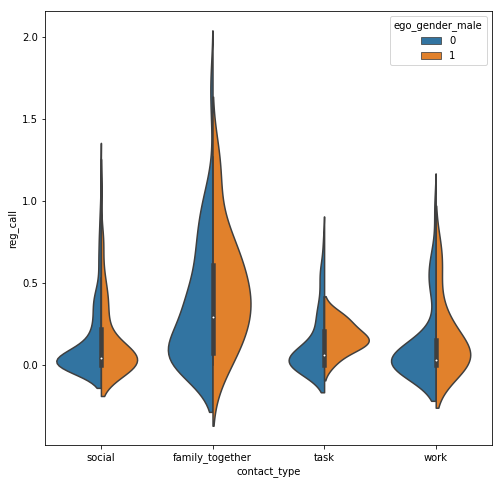

In [304]:
sns.violinplot(x="contact_type", y="reg_call", hue="ego_gender_male", data=ag_features, split=True)
plt.show()

## Zimmerman contact type analysis

In [12]:
z_features = pickle.load(open('../data/final_sandbox/zimmerman_all_train_features.df', 'rb'))

screener_df = pd.read_csv('../CS120/CS120Clinical/CS120Final_Screener.csv', encoding = "ISO-8859-1")
screener_df['pid'] = screener_df['ID']
phq_dict = pd.Series(screener_df['score_PHQ'].values, index=screener_df['pid']).to_dict()
gad_dict = pd.Series(screener_df['score_GAD'].values, index=screener_df['pid']).to_dict()
z_features['ego_phq'] = z_features['pid'].map(phq_dict)
z_features['ego_gad'] = z_features['pid'].map(gad_dict)

In [13]:
z_features_one_hot = pd.concat([z_features, pd.get_dummies(z_features['contact_type'])], axis=1)
z_features_one_hot = z_features_one_hot.drop(['pid', 'combined_hash', 'contact_type'], axis='columns')
cols = z_features_one_hot.columns.values
age_idx = np.where(cols=='ego_age')

In [14]:

def build_pbr_df(features, contact_types):
    """Runs point biserial correlations on given features.
    
    Assumes that the target contact types have been converted to one-hot via pd.get_dummies()
    
    """
    pbr_results = np.zeros((features.columns.values.shape[0], len(contact_types)*2))

    for col_idx, col in enumerate(features.columns.values):
        for contact_idx, contact in enumerate(contact_types):
            r, p = pointbiserialr(features[col], features[contact])
            pbr_results[col_idx, contact_idx*2] = r
            pbr_results[col_idx, (contact_idx*2)+1] = p

    df_cols = []
    for contact in contact_types:
        df_cols.append('t_' + contact)
        df_cols.append('p_' + contact)
    #
    pbr_df = pd.DataFrame(pbr_results, index=cols, columns=df_cols)
    return pbr_df

In [15]:
z_pbr_df = build_pbr_df(z_features_one_hot, ['family', 'social', 'work'])

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [17]:
pd.options.display.float_format = '{:,.3f}'.format
pb_sig_df = z_pbr_df.loc[(z_pbr_df['p_family'] < 0.05) | (z_pbr_df['p_social'] < 0.05) | (z_pbr_df['p_work'] < 0.05)]
pb_sig_df.loc[pb_sig_df.index[pb_sig_df.index.str.startswith("ego")]]

,t_family,p_family,t_social,p_social,t_work,p_work
ego_age,-0.032,0.049,-0.038,0.018,0.078,0.000
ego_gender_female,0.123,0.000,-0.035,0.031,-0.099,0.000
ego_gender_male,-0.114,0.000,0.023,0.156,0.102,0.000
ego_gender_other,-0.045,0.006,0.040,0.014,0.006,0.731
ego_education_associates,-0.019,0.230,-0.043,0.008,0.070,0.000
ego_education_bachelors,-0.045,0.006,0.023,0.163,0.025,0.119
ego_education_completed_hs,0.049,0.003,0.037,0.023,-0.096,0.000
ego_education_masters,-0.020,0.207,-0.028,0.085,0.054,0.001
ego_education_some_hs,0.064,0.000,-0.024,0.141,-0.045,0.006
ego_employment_disability,0.024,0.147,0.069,0.000,-0.102,0.000


## Additional exploratory work

**note**: these analyses probably won't be used for MobiCom

## PHQ

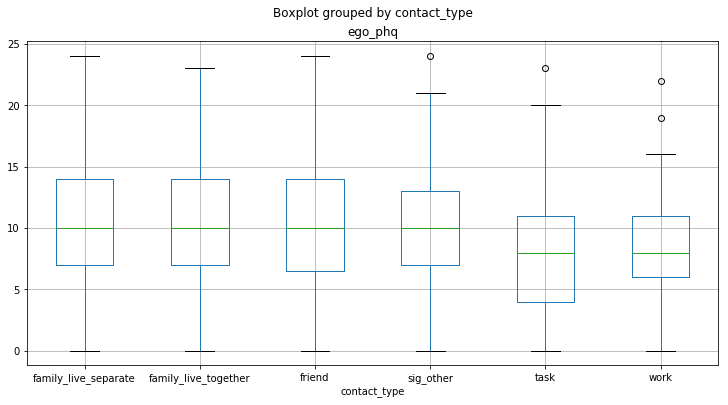

In [29]:
plt.rcParams["figure.figsize"] = [12,6]
ag_features.boxplot(column='ego_phq', by='contact_type')

In [30]:
corr_df = ag_features.drop(labels=['pid','combined_hash', 'contact_type'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')
alpha = 0.01
# plt = build_corr_mat(r_corrs, 
#                      r_p_vals, 
#                      corr_df.columns.values, 
#                      "Across subject pearson correlations, significance* at FDR<{}".format(alpha),
#                      alpha)
# plt.show()

/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu526/miniconda3/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))


In [31]:
cols = corr_df.columns.values
phq_idx = np.where(cols=='ego_phq')

In [32]:
phq_corrs = r_corrs[phq_idx]
phq_p_vals = r_p_vals[phq_idx]

phq_stats = np.transpose(np.vstack((phq_corrs, phq_p_vals)))
phq_df = pd.DataFrame(phq_stats, index=cols, columns=['corr', 'p'])
phq_df.loc[phq_df['p'] < 0.01].sort_values(by='corr')

,corr,p
ego_age,-0.181440,0.000002
std_in_sms,0.104418,0.008735
total_days,0.105578,0.007975
std_out_sms,0.106773,0.007202
day_6_sms,0.125560,0.001377
ego_gad,0.403165,0.000000


### EMC correlations

In [33]:
phq_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

,corr,p
q1_want,-0.007536,0.888121
q2_talk,0.001789,0.972392
q3_loan,-0.045503,0.296546
q4_closeness,-0.001303,0.977015


## GAD

In [ ]:
plt.rcParams["figure.figsize"] = [12,6]
ag_features.boxplot(column='ego_gad', by='contact_type')

In [ ]:
cols = corr_df.columns.values
gad_idx = np.where(cols=='ego_gad')

In [ ]:
gad_corrs = r_corrs[gad_idx]
gad_p_vals = r_p_vals[gad_idx]

gad_stats = np.transpose(np.vstack((gad_corrs, gad_p_vals)))
gad_df = pd.DataFrame(gad_stats, index=cols, columns=['corr', 'p'])
gad_df.loc[gad_df['p'] < 0.01].sort_values(by='corr')

In [ ]:
gad_df.loc[['q1_want', 'q2_talk', 'q3_loan', 'q4_closeness'], :]

In [ ]:
build_lowess_plot(ag_features, "ego_gad", "reg_comm", it=0)

In [ ]:
build_lowess_plot(ag_features, "ego_gad", "avg_out_duration", it=0)

In [ ]:
build_lowess_plot(ag_features, "ego_gad", "q2_talk", it=0)